In [ ]:
# establish / import dependencies
import pandas as pd
import numpy as np
import json
import requests
import citipy 
from citipy import citipy

from config import  weather_key

openweather_url = "http://api.openweathermap.org/data/2.5/weather?"

In [ ]:
# getting rand floats for city coordinates
lat = np.random.uniform(-90, 90,5000) 
long = np.random.uniform(-180, 180,5000)

# add these to dataframe to be referenced as city locations
coordinates = pd.DataFrame()
coordinates['Latitude'] = lat
coordinates['Longitude'] = long

coordinates.head()

In [ ]:
# getting city names from the dataframe of random geograpgical locations
cities_pd = pd.DataFrame()

cities = []

# loop through all coordinates and find city name
for index, row in coordinates.iterrows():

    lat = row['Latitude']
    long = row['Longitude']

    city = citipy.nearest_city(lat,long)
    city_name = city.city_name
    
    if city not in cities:
        cities.append(city)
    
    # add the cities to a dataframe 
    cities_pd.loc[index,"City"] = city_name
    cities_pd.loc[index,"Latitude"] = lat
    cities_pd.loc[index,"Longitude"] = long

cities_pd = cities_pd.drop_duplicates(['City'])
print(len(cities_pd['City']))

In [ ]:
# loop through all cities, call API and pull weather data

# empty array for data
city_data = []

not_found = []
for index,row in cities_pd.iterrows():
    city = row["City"]
    
    # unique city search url
    query_url = openweather_url + "appid=" + weather_key + "&q=" + city

    # try/except to pass any cities not found
    try:
        city_weather = requests.get(query_url).json()
        
        city_id = city_weather["sys"]["id"]
        lat = city_weather["coord"]["lat"]
        lng = city_weather["coord"]["lon"]
        temp = city_weather["main"]["temp"]
        humidity = city_weather["main"]["humidity"]
        clouds = city_weather["clouds"]["all"]
        wind = city_weather["wind"]["speed"]
        country = city_weather["sys"]["country"]
        weather_description = city_weather["weather"][0]["description"]       
            
            # add the weather data into city_data list
        city_data.append({"City": city.title(),
                          "City ID": city_id, 
                          "Latitude": lat, 
                          "Longitude": lng, 
                          "Temperature": temp,
                          "Weather Description": weather_description,
                          "Humidity": humidity,
                          "Cloudiness": clouds,
                          "Wind Speed": wind,
                          "Country": country})
    # If an error is experienced, skip the city

    except:
        not_found.append(city)
        # print(f"{city} not found.")
        pass

In [ ]:
# convert the results of the API loop into a dataframe 
city_data_df = pd.DataFrame(city_data)

print(len(city_data_df['City']))
# city_data_df = city_data_df.drop_duplicates()
# print(len(city_data_df['City']))

# correct the units of temperature to Fahrenheit and wind speed to mph
city_data_df['Temperature'] = (city_data_df['Temperature']-273.15) * (9/5) + 32
city_data_df['Wind Speed'] = (city_data_df['Wind Speed'] * 2.23694)

city_data_df.head()
# for some reason citipy produces up to 60% duplicate cities

In [ ]:
# import dependencies and modules for plotting
import matplotlib
from matplotlib import pyplot as plt
from scipy import  stats

# establish plot-able data variables
temperature = city_data_df['Temperature']
humidity = city_data_df['Humidity']
cloud_cover = city_data_df['Cloudiness']
wind_speed = city_data_df['Wind Speed']
latitude = city_data_df['Latitude']



In [ ]:
# Temperature vs. Latitude
lat_labels = np.arange(-90,90,10)
plt.scatter(latitude,temperature)
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.title('Temperature vs. Latitude')

In [ ]:
# Humidity vs. Latitude
lat_labels = np.arange(-90,90,10)
plt.scatter(latitude,humidity)
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('Humidity vs. Latitude')

In [ ]:
# cloud cover vs latitude
lat_labels = np.arange(-90,90,10)
plt.scatter(latitude,cloud_cover)
plt.xlabel('Latitude')
plt.ylabel('Cloud Cover (%)')
plt.title('Cloud Cover vs. Latitude')

In [ ]:
# wind speed vs latitude
lat_labels = np.arange(-90,90,10)
plt.scatter(latitude,wind_speed)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed(mph)')
plt.title('Wind Speed(mph) vs. Latitude')

In [ ]:
# separate cities into northern/southern dataframes for separate analysis

north_cities = city_data_df.loc[city_data_df['Latitude']>0]
south_cities = city_data_df.loc[city_data_df['Latitude']<0]

north_cities.head()
south_cities.head()

In [ ]:
# north & south variables
from scipy.stats import linregress

temp_north = north_cities['Temperature']
hum_north = north_cities['Humidity']
cloud_north = north_cities['Cloudiness']
wind_north = north_cities['Wind Speed']
lat_north = north_cities['Latitude']

temp_south = south_cities['Temperature']
hum_south = south_cities['Humidity']
cloud_south = south_cities['Cloudiness']
wind_south = south_cities['Wind Speed']
lat_south = south_cities['Latitude']


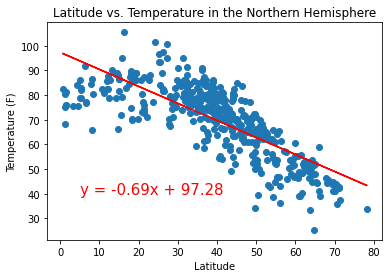

In [98]:
# north_cities temp vs. lat graph and regression

plt.scatter(lat_north,temp_north)
plt.title("Latitude vs. Temperature in the Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_north, temp_north)

regress_values = lat_north * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_north,regress_values,"r-")
plt.annotate(line_eq,(5,40),fontsize=15,color="red")

plt.show()

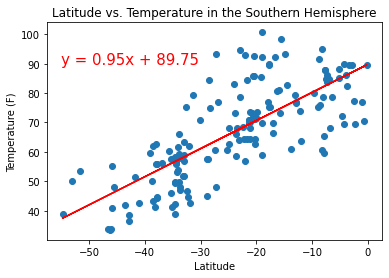

In [64]:
# south_cities temp vs. lat graph and regression

plt.scatter(lat_south,temp_south)
plt.title("Latitude vs. Temperature in the Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_south,temp_south)

regress_values = lat_south * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_south,regress_values,"r-")
plt.annotate(line_eq,(-55,90),fontsize=15,color="red")

plt.show()

This regression is showing the relationship between Northern Hemisphere latitudes and temperatures. As the latitude goes further north (approaching the North Pole), the temperature on the given date decreases. There appears to be more cities in the Northern Hemisphere, especially cities closer to the North Pole. The cities that are furthest north are about 20 degrees of latitude closer to their respective Pole than cities in the Southern Hemisphere. This is absolutely due to the fact that 68% of the land mass is north of the equator.

Similarly, as the latitude goes further south (approaching the South Pole), the temperature on the given date decreases.

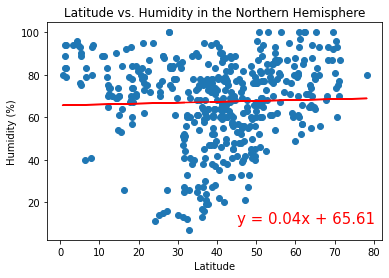

In [63]:
# north_cities humidity vs. lat graph and regression

plt.scatter(lat_north,hum_north)
plt.title("Latitude vs. Humidity in the Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_north,hum_north)

regress_values = lat_north * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_north,regress_values,"r-")
plt.annotate(line_eq,(45,10),fontsize=15,color="red")

plt.show()

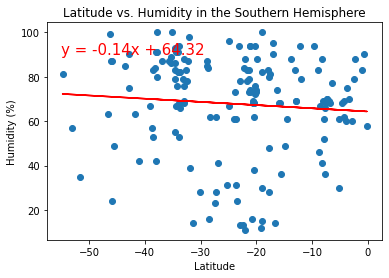

In [65]:
# south_cities humidity vs. lat graph and regression

plt.scatter(lat_south,hum_south)
plt.title("Latitude vs. Humidity in the Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_south,hum_south)

regress_values = lat_south * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_south,regress_values,"r-")
plt.annotate(line_eq,(-55,90),fontsize=15,color="red")

plt.show()

Based on the regression line, it appears here that the humidity is ever so slightly lower towards the equator, however it is visually apparent that the datapoints are very spread out along the distribution. As found in the temperature graphs, there are more cities in the Northern Hemishpere. 

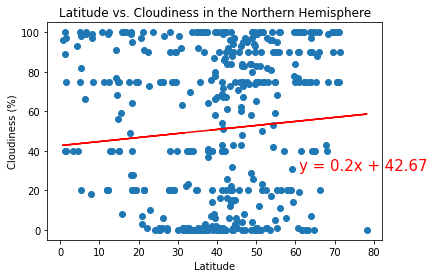

In [87]:
# north_cities cloudiness vs. lat graph and regression

plt.scatter(lat_north,cloud_north)
plt.title("Latitude vs. Cloudiness in the Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_north,cloud_north)

regress_values = lat_north * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_north,regress_values,"r-")
plt.annotate(line_eq,(61,30),fontsize=15,color="red")

plt.show()

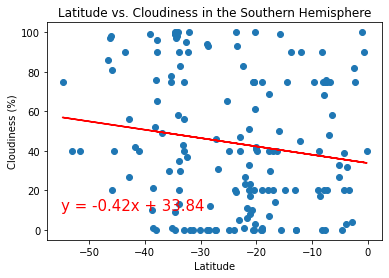

In [88]:
# north_cities cloudiness vs. lat graph and regression

plt.scatter(lat_south,cloud_south)
plt.title("Latitude vs. Cloudiness in the Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_south,cloud_south)

regress_values = lat_south * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_south,regress_values,"r-")
plt.annotate(line_eq,(-55,10),fontsize=15,color="red")

plt.show()

The graphs of cloudiness are maybe the most interesting to me. Going on the fact that there are many datapoints on exact percentage lines, some stations apparently do not classify cloudiness or cloud cover with accurate percentages. Instead, it looks like they just measure in increments of 5/10%.

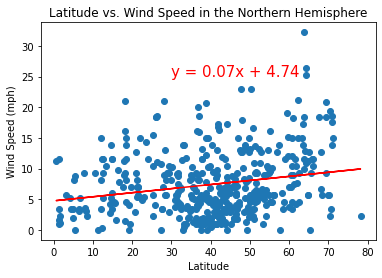

In [96]:
# north_cities wind speed vs. lat graph and regression

plt.scatter(lat_north,wind_north)
plt.title("Latitude vs. Wind Speed in the Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_north,wind_north)

regress_values = lat_north * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_north,regress_values,"r-")
plt.annotate(line_eq,(30,25),fontsize=15,color="red")

plt.show()

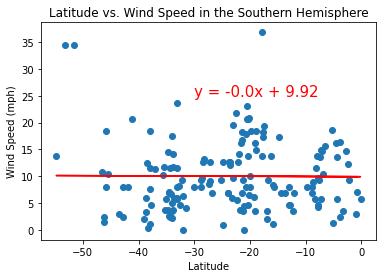

In [97]:
# north_cities wind speed vs. lat graph and regression

plt.scatter(lat_south,wind_south)
plt.title("Latitude vs. Wind Speed in the Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

(slope, intercept, rvalue, pvalue, stderr) = linregress(lat_south,wind_south)

regress_values = lat_south * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(lat_south,regress_values,"r-")
plt.annotate(line_eq,(-30,25),fontsize=15,color="red")

plt.show()

The wind speed regression is not great for finding relationships. Both Slope lines are very slight, but in the Northern Hemisphere it appears that wind speeds increase marginally as you approach the North Pole.